In [ ]:
from __future__ import annotations

from fastai.vision.all import *
from numbers import Real
from collections.abc import MutableSequence

# Schedulers

fastai has its own scheduler implementation which we will walk through from the ground up.

It uses `_Annealer` to transform a function `sched_cos` which takes a `(start, end, pos)` to `SchedCos`, a class which is initialized with `(start, end)`, and is called with `pos` returning the schedule.

In [ ]:
class _Annealer:
    def __init__(self, f, start, end): 
        store_attr('f,start,end')

    def __call__(self, pos): 
        return self.f(self.start, self.end, pos)


def sched_cos(start, end, pos):
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2


def SchedCos(start, end):
    "Cosine schedule function from `start` to `end`"
    return _Annealer(sched_cos, start, end)

`SchedCos` is a Cosine schedule. There are also `SchedLin`, `SchedNo`, `SchedExp`, and `SchedPoly`, which are Linear, Constant, Exponential, and Polynomial schedules, respectively.

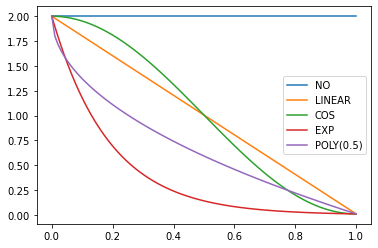

In [ ]:
def combine_scheds(pcts, scheds):
    "Combine `scheds` according to `pcts` in one function"
    assert sum(pcts) == 1.
    pcts = tensor([0] + L(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    pct_lim = len(pcts) - 2
    def _inner(pos):
        idx = min((pos >= pcts).nonzero().max(), pct_lim)
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos.item())
    return _inner

There are methods for combining schedules together, such as `combine_scheds` which requires lists of `pcts` percentages and schedules `scheds` (the `pcts` must all add up to 1) and combines the two or more schedules into one schedule.

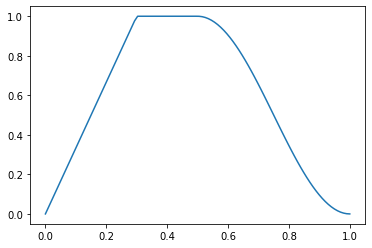

And also a convenience method `combined_cos` for combining multiple cosine schedules.

In [ ]:
def combined_cos(pct, start, middle, end):
    "Return a scheduler with cosine annealing from `start`→`middle` & `middle`→`end`"
    return combine_scheds([pct,1-pct], [SchedCos(start, middle), SchedCos(middle, end)])

Schedules can be run independently by any callback, but when training fastai uses the `ParamScheduler` callback to update `Optimizer` hyperparameters.

This callback takes a dictionary of schedules and each batch loops through all schedules in `before_batch` and `after_batch` to set and record the `Optimizer` hyperparameters.

In [ ]:
class ParamScheduler(Callback):
    "Schedule hyper-parameters according to `scheds`"
    order,run_valid = 60,False

    def __init__(self, scheds): 
        self.scheds = scheds

    def before_fit(self):
        "Initialize container for hyper-parameters"
        self.hps = {p:[] for p in self.scheds.keys()}
    
    def before_batch(self):
        "Set the proper hyper-parameters in the optimizer"
        self._update_val(self.pct_train)

    def _update_val(self, pct):
        for n,f in self.scheds.items(): 
            self.opt.set_hyper(n, f(pct))

    def after_batch(self):
        "Record hyper-parameters of this batch"
        for p in self.scheds.keys(): 
            self.hps[p].append(self.opt.hypers[-1][p])

    def after_fit(self):
        "Save the hyper-parameters in the recorder if there is one"
        if hasattr(self.learn, 'recorder') and hasattr(self, 'hps'): 
            self.recorder.hps = self.hps

Using all these pieces, we can then create `fit_one_cycle`, a convenience method for applying One Cycle Schedule while training models.

`fit_one_cycle` is a patched method, which means it is added to `Learner` due to `self:Learner`.

We construct a dictionary of schedules, using `combined_cos` for both the learning rate and the momentum to create the cosine and inverted cosine schedules, then pass the dictionary to the `ParamScheduler` callback.

In [ ]:
@patch
def fit_one_cycle(self:Learner, 
    n_epoch:int, # Number of epochs
    lr_max:float|slice|None=None, # Maximum learning rate
    div:Real=25., # Initial learning rate: `lr/div`
    div_final:Real=1e5, # Final learning rate: `lr/div_final`
    pct_start:float=0.25, # Start one cycle cosine annealing
    wd:float|None=None, # Weight decay, defaults to `Optimizer` weight decay
    moms:float|tuple|None=None, # One cycle momentum, defaults to `Learner` momentum
    cbs:Callback|MutableSequence|None=None, # Temporary Callbacks to apply during fit
    reset_opt:bool=False, # Reset `Optimizer` before fit
    start_epoch:int=0 # Starting epoch
):
    "Fit `self.model` for `n_epoch` using the one cycle policy."
    if self.opt is None: 
        self.create_opt()

    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    lr_max = np.array([h['lr'] for h in self.opt.hypers])

    scheds = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final),
              'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))}

    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)

Before we created the schedulers, we call `set_hyper` on the `Optimizer` in our `Learner` for the learning rate. This method will turn a slice of learning rates into per-parameter group values, stepping evenly across the `Optimizer.param_lists`.

After converting slices to parameter group hyperparameters, `fit_one_cycle` grabs them from the optimizer to use when constructing the schedulers.

In [ ]:
def set_hyper(self,
    k, # Hyperparameter key
    v # Hyperparameter value or slice of values
):
    if isinstance(v, slice):
        if v.start: 
            v = even_mults(v.start, v.stop, len(self.param_lists))
        else: 
            v = [v.stop/10]*(len(self.param_lists)-1) + [v.stop]

    v = L(v, use_list=None)

    if len(v)==1: 
        v = v*len(self.param_lists)
    assert len(v) == len(self.hypers), f"Trying to set {len(v)} values for {k} but there are {len(self.param_lists)} parameter groups."

    self._set_hyper(k, v)


def _set_hyper(self,
    k, # Hyperparameter key
    v # Hyperparameter value
):
    for v_,h in zip(v, self.hypers): 
        h[k] = v_